In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



TREE INSTANCE SEGMENTATION - COCO FORMAT CONVERSION

Input:  /content/drive/MyDrive/mask2former_task/preprocessed_data
Output: /content/drive/MyDrive/mask2former_task/coco_format


Converting TRAIN data to COCO format

Found 487 patches to convert



Processing train: 100%|██████████| 487/487 [02:58<00:00,  2.72it/s]



📝 Saving COCO annotations to: /content/drive/MyDrive/mask2former_task/coco_format/instances_train.json

✅ COCO Conversion Complete for TRAIN

📊 Statistics:
  Images:              487
  Annotations:         2648
  Total instances:     2648
  Skipped (too small): 3
  Avg instances/image: 5.4

📁 Output: /content/drive/MyDrive/mask2former_task/coco_format/instances_train.json


Converting VAL data to COCO format

Found 165 patches to convert



Processing val: 100%|██████████| 165/165 [01:00<00:00,  2.73it/s]



📝 Saving COCO annotations to: /content/drive/MyDrive/mask2former_task/coco_format/instances_val.json

✅ COCO Conversion Complete for VAL

📊 Statistics:
  Images:              165
  Annotations:         832
  Total instances:     832
  Skipped (too small): 0
  Avg instances/image: 5.0

📁 Output: /content/drive/MyDrive/mask2former_task/coco_format/instances_val.json


FINAL SUMMARY

📊 Dataset Statistics:

  Training:
    - Images:    487
    - Instances: 2648
    - File:      /content/drive/MyDrive/mask2former_task/coco_format/instances_train.json

  Validation:
    - Images:    165
    - Instances: 832
    - File:      /content/drive/MyDrive/mask2former_task/coco_format/instances_val.json

  Total:
    - Images:    652
    - Instances: 3480

✅ COCO conversion complete!

Validating COCO files...


Validating COCO Format

✓ All required top-level keys present
✓ Categories: 1
   - ID 1: tree
✓ Images: 487
✓ Image structure valid (sample: 1000.png)
✓ Annotations: 2648
✓ Annotation structur

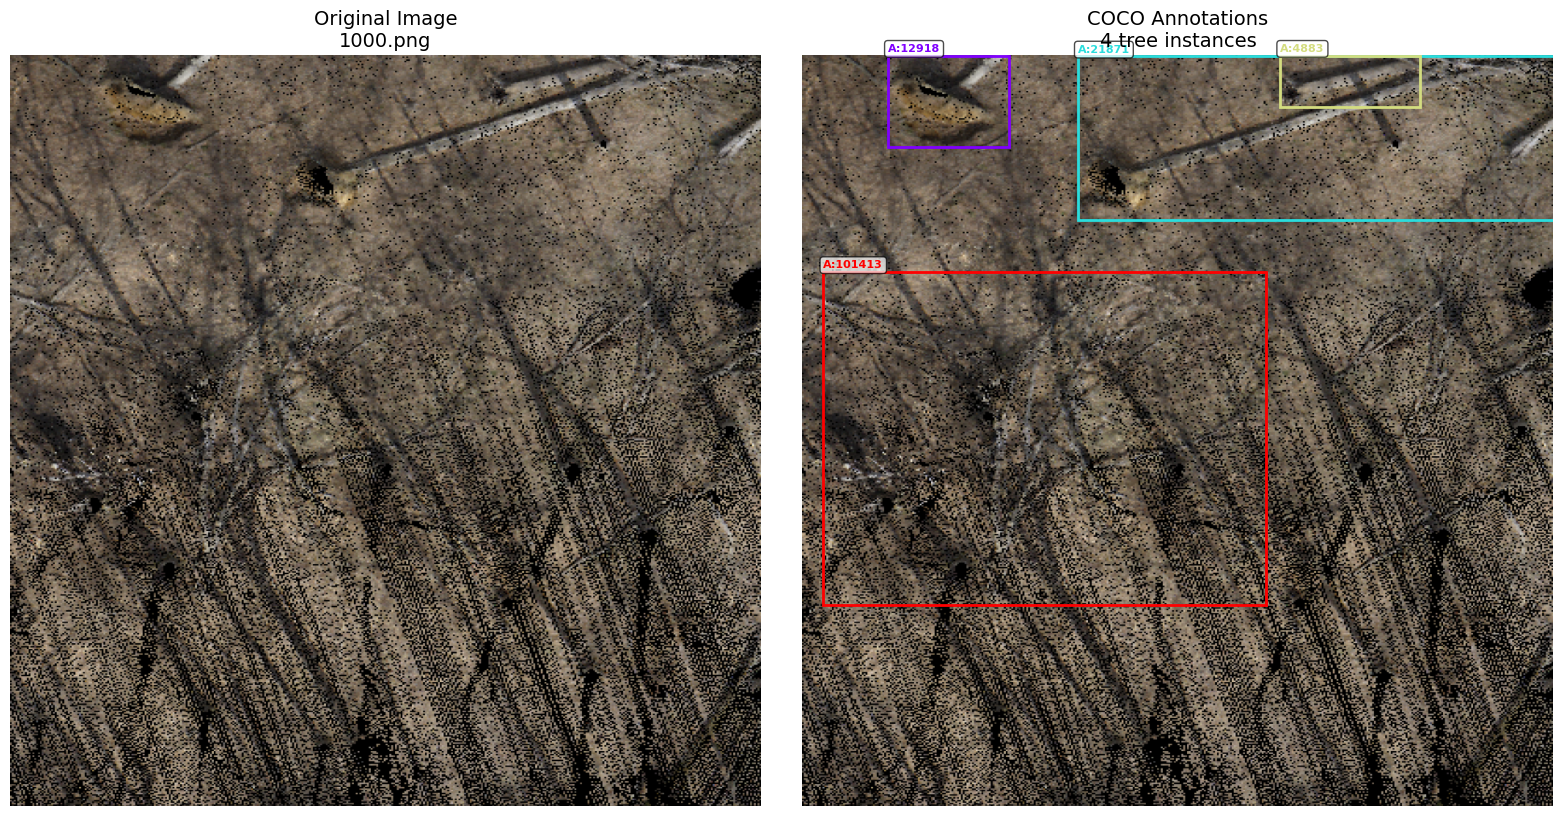

✓ Visualization saved to: /content/drive/MyDrive/mask2former_task/coco_format/coco_visualization_1000.png


🎯 Next Steps:

1. Register dataset with Detectron2
2. Configure Mask2Former for training
3. Start training!




In [ ]:
# Tree Instance Segmentation - Convert to COCO Format
# Import

import json
import cv2
import numpy as np
import os
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
from pycocotools import mask as mask_utils

# Configuration

PREPROCESSED_DIR = "/content/drive/MyDrive/mask2former_task/preprocessed_data"
COCO_OUTPUT_DIR = "/content/drive/MyDrive/mask2former_task/coco_format"

# COCO Conversion Function

def create_coco_annotations(preprocessed_dir, output_dir, split="train"):


    print(f"\n{'='*70}")
    print(f"Converting {split.upper()} data to COCO format")
    print(f"{'='*70}\n")

    png_dir = Path(preprocessed_dir) / f"{split}_PNG"
    mask_dir = Path(preprocessed_dir) / f"{split}_MASK"
    output_path = Path(output_dir) / f"instances_{split}.json"

    os.makedirs(output_dir, exist_ok=True)

    # Initialize COCO structure
    coco_data = {
        "info": {
            "description": "Tree Instance Segmentation Dataset",
            "url": "",
            "version": "1.0",
            "year": 2025,
            "contributor": "Tree Detection Team",
            "date_created": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        },
        "licenses": [
            {
                "id": 1,
                "name": "Unknown",
                "url": ""
            }
        ],
        "categories": [
            {
                "id": 1,
                "name": "tree",
                "supercategory": "plant"
            }
        ],
        "images": [],
        "annotations": []
    }

    png_files = sorted([f for f in os.listdir(png_dir)
                       if f.endswith('.png') and '_bbox' not in f and '_mask' not in f])

    print(f"Found {len(png_files)} patches to convert\n")

    annotation_id = 1
    total_instances = 0
    skipped_instances = 0

    # Process each patch
    for png_file in tqdm(png_files, desc=f"Processing {split}"):
        # Extract patch ID from filename
        patch_id = int(png_file.replace('.png', ''))

        mask_file = f"{patch_id}_mask.png"
        mask_path = mask_dir / mask_file

        if not mask_path.exists():
            print(f"Warning: Mask not found for {png_file}, skipping...")
            continue

        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if mask is None:
            print(f"Warning: Could not read mask {mask_file}, skipping...")
            continue

        height, width = mask.shape

        # Add image entry
        image_entry = {
            "id": patch_id,
            "file_name": png_file,
            "height": height,
            "width": width,
            "license": 1,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": ""
        }
        coco_data["images"].append(image_entry)

        # Extract individual instances from mask
        instance_ids = np.unique(mask)
        instance_ids = instance_ids[instance_ids > 0]  # Remove background

        for inst_id in instance_ids:
            binary_mask = (mask == inst_id).astype(np.uint8)

            area = float(np.sum(binary_mask))

            if area < 10:
                skipped_instances += 1
                continue

            contours, _ = cv2.findContours(
                binary_mask,
                cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE
            )

            if len(contours) == 0:
                skipped_instances += 1
                continue

            # Get bounding box from largest contour
            contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(contour)
            bbox = [float(x), float(y), float(w), float(h)]

            # Convert binary mask to RLE (Run Length Encoding)
            rle = mask_utils.encode(np.asfortranarray(binary_mask))
            rle['counts'] = rle['counts'].decode('utf-8')

            # Create annotation entry
            annotation = {
                "id": annotation_id,
                "image_id": patch_id,
                "category_id": 1,  # tree class
                "segmentation": rle,
                "area": area,
                "bbox": bbox,
                "iscrowd": 0
            }

            coco_data["annotations"].append(annotation)
            annotation_id += 1
            total_instances += 1

    print(f"\n📝 Saving COCO annotations to: {output_path}")
    with open(output_path, 'w') as f:
        json.dump(coco_data, f, indent=2)

    print(f"\n{'='*70}")
    print(f"COCO Conversion Complete for {split.upper()}")
    print(f"{'='*70}")
    print(f"\n Statistics:")
    print(f"  Images:              {len(coco_data['images'])}")
    print(f"  Annotations:         {len(coco_data['annotations'])}")
    print(f"  Total instances:     {total_instances}")
    print(f"  Skipped (too small): {skipped_instances}")
    print(f"  Avg instances/image: {total_instances / len(coco_data['images']):.1f}")
    print(f"\n Output: {output_path}")
    print(f"{'='*70}\n")

    return output_path, len(coco_data['images']), total_instances


# Validation Function

def validate_coco_format(coco_json_path):
    """
    Validate the generated COCO JSON file.

    """
    print(f"\n{'='*70}")
    print("Validating COCO Format")
    print(f"{'='*70}\n")

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    required_keys = ['info', 'licenses', 'categories', 'images', 'annotations']
    missing_keys = [k for k in required_keys if k not in coco_data]

    if missing_keys:
        print(f"Error: Missing required keys: {missing_keys}")
        return False

    print("All required top-level keys present")

    # Validate categories
    if len(coco_data['categories']) == 0:
        print("Error: No categories defined")
        return False
    print(f"Categories: {len(coco_data['categories'])}")
    for cat in coco_data['categories']:
        print(f"   - ID {cat['id']}: {cat['name']}")

    # Validate images
    if len(coco_data['images']) == 0:
        print("Error: No images found")
        return False
    print(f"Images: {len(coco_data['images'])}")

    first_img = coco_data['images'][0]
    img_required = ['id', 'file_name', 'height', 'width']
    img_missing = [k for k in img_required if k not in first_img]
    if img_missing:
        print(f" Error: Image missing fields: {img_missing}")
        return False
    print(f" Image structure valid (sample: {first_img['file_name']})")

    # Validate annotations
    if len(coco_data['annotations']) == 0:
        print("Warning: No annotations found")
        return True
    print(f"Annotations: {len(coco_data['annotations'])}")

    first_ann = coco_data['annotations'][0]
    ann_required = ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd']
    ann_missing = [k for k in ann_required if k not in first_ann]
    if ann_missing:
        print(f" Error: Annotation missing fields: {ann_missing}")
        return False
    print(f"Annotation structure valid")

    # Check RLE format
    if isinstance(first_ann['segmentation'], dict):
        if 'counts' in first_ann['segmentation'] and 'size' in first_ann['segmentation']:
            print(f" Segmentation format: RLE (compressed)")
        else:
            print(f"Warning: Unexpected segmentation dict structure")
    else:
        print(f"Warning: Segmentation is not in RLE format")

    # Check image-annotation consistency
    image_ids = set(img['id'] for img in coco_data['images'])
    ann_image_ids = set(ann['image_id'] for ann in coco_data['annotations'])
    orphan_anns = ann_image_ids - image_ids
    if orphan_anns:
        print(f"Warning: {len(orphan_anns)} annotations reference missing images")
    else:
        print(f" All annotations reference valid images")

    category_ids = set(cat['id'] for cat in coco_data['categories'])
    ann_category_ids = set(ann['category_id'] for ann in coco_data['annotations'])
    invalid_cats = ann_category_ids - category_ids
    if invalid_cats:
        print(f"Error: Annotations use invalid category IDs: {invalid_cats}")
        return False
    print(f"✓ All category IDs valid")

    print(f"\n{'='*70}")
    print("✅ COCO format validation PASSED")
    print(f"{'='*70}\n")

    return True


# Visualization Function

def visualize_coco_sample(coco_json_path, preprocessed_dir, sample_image_id=None):
    """
    Visualize a sample image with COCO annotations.

    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image

    print(f"\n{'='*70}")
    print("Creating Visualization")
    print(f"{'='*70}\n")

    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    split = "train" if "train" in str(coco_json_path) else "val"
    png_dir = Path(preprocessed_dir) / f"{split}_PNG"

    if sample_image_id is None:
        image_info = coco_data['images'][0]
    else:
        image_info = next((img for img in coco_data['images'] if img['id'] == sample_image_id), None)
        if image_info is None:
            print(f" Image ID {sample_image_id} not found")
            return

    img_path = png_dir / image_info['file_name']
    image = np.array(Image.open(img_path))

    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_info['id']]

    print(f"Image: {image_info['file_name']}")
    print(f"Instances: {len(annotations)}\n")

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title(f"Original Image\n{image_info['file_name']}", fontsize=14)
    axes[0].axis('off')

    # Plot with annotations
    axes[1].imshow(image)
    axes[1].set_title(f"COCO Annotations\n{len(annotations)} tree instances", fontsize=14)
    axes[1].axis('off')

    # Draw bounding boxes
    colors = plt.cm.rainbow(np.linspace(0, 1, len(annotations)))
    for ann, color in zip(annotations, colors):
        x, y, w, h = ann['bbox']
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor=color,
            facecolor='none'
        )
        axes[1].add_patch(rect)

        axes[1].text(
            x, y - 5,
            f"A:{int(ann['area'])}",
            color=color,
            fontsize=8,
            weight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7)
        )

    plt.tight_layout()

    output_path = Path(coco_json_path).parent / f"coco_visualization_{image_info['id']}.png"
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Visualization saved to: {output_path}\n")


# Main Execution

def main():
    """
    Main function to convert all data to COCO format.
    """
    print("\n" + "="*70)
    print("TREE INSTANCE SEGMENTATION - COCO FORMAT CONVERSION")
    print("="*70)
    print(f"\nInput:  {PREPROCESSED_DIR}")
    print(f"Output: {COCO_OUTPUT_DIR}\n")

    # Convert training data
    train_json, train_images, train_instances = create_coco_annotations(
        PREPROCESSED_DIR,
        COCO_OUTPUT_DIR,
        split="train"
    )

    # Convert validation data
    val_json, val_images, val_instances = create_coco_annotations(
        PREPROCESSED_DIR,
        COCO_OUTPUT_DIR,
        split="val"
    )

    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    print(f"\n Dataset Statistics:")
    print(f"\n  Training:")
    print(f"    - Images:    {train_images}")
    print(f"    - Instances: {train_instances}")
    print(f"    - File:      {train_json}")
    print(f"\n  Validation:")
    print(f"    - Images:    {val_images}")
    print(f"    - Instances: {val_instances}")
    print(f"    - File:      {val_json}")
    print(f"\n  Total:")
    print(f"    - Images:    {train_images + val_images}")
    print(f"    - Instances: {train_instances + val_instances}")

    print(f"\n{'='*70}")
    print("COCO conversion complete!")
    print(f"{'='*70}\n")

    print("Validating COCO files...\n")
    validate_coco_format(train_json)
    validate_coco_format(val_json)

    print("Creating sample visualization...")
    visualize_coco_sample(train_json, PREPROCESSED_DIR)

    print("\n" + "="*70)
    print(" Next Steps:")
    print("="*70)
    print("\n1. Register dataset with Detectron2")
    print("2. Configure Mask2Former for training")
    print("3. Start training!")
    print("\n" + "="*70 + "\n")


if __name__ == "__main__":
    main()